In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyscf import ao2mo,gto, scf

from typing import Tuple


# qiskit
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, NELDER_MEAD
from qiskit.algorithms import MinimumEigensolverResult

from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.quantum_info.operators import Operator
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit.opflow.primitive_ops import PauliOp, PauliSumOp
from qiskit.quantum_info import Pauli, SparsePauliOp

# qiskit nature
from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.mappers import ParityMapper, QubitConverter
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.problems import ElectronicBasis
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)

from qiskit_nature.settings import settings
settings.dict_aux_operators = True

from qiskit import IBMQ
from qiskit_nature.runtime import VQEClient
from qiskit.providers.ibmq import least_busy
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session

# useful??
#from qiskit_nature.algorithms import (GroundStateEigensolver,
#                                      NumPyMinimumEigensolverFactory)
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.library import RealAmplitudes
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.opflow import TwoQubitReduction

In [2]:
IBMQ.load_account()
service = QiskitRuntimeService() #load account
provider = IBMQ.get_provider()
real_backend = provider.get_backend('ibmq_manila') # or other quantum device
noise_model = NoiseModel.from_backend(real_backend)
backend = provider.get_backend('ibmq_qasm_simulator')
backend.set_options(noise_model=noise_model)
# backend = provider.get_backend('ibm_nairobi')
can_use_runtime = provider.has_service('runtime')
can_use_runtime

True

In [3]:
qdev = provider.backends(simulator=False, operational=True)
least_busy(qdev)

<IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
def get_molecular_integrals(molecule):
    '''
    Calculates the 1-electron and 2-electron integrals.
    
    Args:   
        molecule : Mole 
            Ccorresponds to the molecule.
            
    Returns:
        h1_MO : ndarray
                Tensor corresponding to the 1-electron integral in the molecular basis.
        
        h2_MO : ndarray
                Tensor corresponding to the 2-electron integral in the molecular basis.

        n_particles: Tuple[int, int]
            Number of alpha and beta electrons.
        
        num_orb : int 
            Number of orbitals.

        nuclear_repulsion_energy : float
            Nuclear repulsion energy.
    '''
    
    mf = scf.RHF(molecule).run()

    # computing the 1e and 2e AO (atomic orbitals) integrals 
    h1 = molecule.intor_symmetric("int1e_nuc") + molecule.intor_symmetric("int1e_kin") 
    h2 = molecule.intor("int2e")
    # comment : add aosym (axis of symmetry) ???

    # transformations from AO to MO (molecular orbitals)
    h1_MO = np.einsum('pi,pq,qj->ij', mf.mo_coeff, h1, mf.mo_coeff)
    h2_MO = ao2mo.get_mo_eri(h2, mf.mo_coeff)

    #h2_MO = ao2mo.kernel(mol_h2, mf.mo_coeff, aosym="1") #alternative

    nuclear_repulsion_energy=molecule.energy_nuc()
    num_particles = molecule.nelec
    num_orb = h1.shape[0]

    return h1_MO, h2_MO, num_particles, num_orb, nuclear_repulsion_energy


def get_qubit_op(coordinates):
    '''
    Calculates the Hamiltonian as the sum of Pauli operators as a function
    of the coordinates of the atoms.
    
    Args:
        coordinates : ndarray
            Array containing the positions of the atoms constituing the molecule.
        
    
    Returns:
        qubit_op : PauliSumOp
            Sum of Pauli operators corresponding to the Hamiltonian.
        
        nelec : Tuple[int, int]
            Number of alpha and beta electrons.
        
        norb : int 
            Number of orbitals.
            
        problem : ElectronicStructureProblem
        
        converter : QubitConverter
    '''
    
    mol = gto.M(
                atom = [['H',(coordinates[0], coordinates[1], 0.0)], 
                        ['H',(coordinates[2], coordinates[3], 0.0)],
                        ['H',(coordinates[4], coordinates[5], 0.0)]],
                basis = 'sto3g',
                charge = 1,
                spin = 0,
                symmetry = True,
                verbose = 2 # control the print level of PySCF globally
    )

    h1_MO,h2_MO,nelec,norb,ecore = get_molecular_integrals(mol)

    # Define an ElectronicEnergy instance containing the 1e and 2e integrals
    electronic_energy = ElectronicEnergy.from_raw_integrals(
            h1_MO, ao2mo.restore(1, h2_MO, norb)
        )
    electronic_energy.nuclear_repulsion_energy = ecore

    # Define an ElectronicStructureProblem
    problem = ElectronicStructureProblem(electronic_energy)

    second_q_ops = problem.second_q_ops()     # get second quantized operators
    problem.num_spatial_orbitals = norb  # define number of orbitals
    problem.num_particles = nelec        # define number of particles 
    
    problem.basis = ElectronicBasis.MO 
    
    problem.molecule=MoleculeInfo(symbols=[mol.atom_symbol(i) for i in range(mol.nbas)], 
                                  coords=mol.atom_coords())
    FC_transformer=FreezeCoreTransformer(freeze_core=True)
    problem = FC_transformer.transform(problem)
    
    # TODO we need to give info about the molecule to use FreezeCoreTransformer 
    # question : how to do it in a smart way ? at the initialization ??
    
    hamiltonian = second_q_ops[0]  # Set electronic part of Hamiltonian
    hamiltonian = (hamiltonian + FermionicOp({"": ecore}, num_spin_orbitals=norb)) # add Nuclear Repulsion Energy
    #print("Hamiltonian :\n", hamiltonian) # print for checking purposes
    
    mapper = ParityMapper()  # Set Mapper
    
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    qubit_op = converter.convert(hamiltonian, nelec)
    #print("q_op :\n", qubit_op) # print for checking purposes
    

    return qubit_op, nelec, norb, problem, converter

In [4]:
def calc_ground_state(qubit_op,nelec,norb,problem,converter) :
    '''
    Calculates the ground state and the ground energy of the Hamiltonian.
    
    Args:
        qubit_op : PauliSumOp
            Sum of Pauli operators corresponding to the Hamiltonian.
        
        nelec : Tuple[int, int]
            Number of alpha and beta electrons.
        
        norb : int 
            Number of orbitals.
            
        problem : ElectronicStructureProblem
        
        converter : QubitConverter
        
    
    Returns:
        ground_state : CircuitStateFn
            Ground state of the Hamiltonian.
            
        min_eng : float
            Ground energy of the Hamiltonian.
    '''

    backend = BasicAer.get_backend("statevector_simulator")
    quantum_instance = QuantumInstance(backend)
    optimizer = SLSQP(maxiter=400)

    init_state = HartreeFock(num_spatial_orbitals=norb, 
                                num_particles=nelec, 
                                qubit_converter=converter
                            )
    
    var_form = UCCSD(qubit_converter=converter,
                        num_particles=nelec,
                        num_spatial_orbitals=norb, 
                        initial_state=init_state
                        )

    vqe = VQE(var_form, optimizer, quantum_instance=quantum_instance) 
    vqe_result = vqe.compute_minimum_eigenvalue(qubit_op)
    min_eng = vqe_result.eigenvalue.real
    final_params = vqe_result.optimal_parameters 

    vqe_ground = vqe.ansatz.bind_parameters(final_params) 
#     vqe_ground_state = CircuitStateFn(vqe_ground)
    
    return vqe_ground, min_eng

def get_psi_0(coordinates):
       
    #get qubit operator corresponding to H(R)
    (qubit_op, num_part, num_orb, problem, converter) = get_qubit_op(coordinates)
    #get the ground state of H(R)
    psi_0,_ = calc_ground_state(qubit_op,num_part, num_orb, problem, converter)

    return psi_0

def distance(coordinates1,coordinates2):
    return np.sqrt(np.power((coordinates1[0] - coordinates2[0]),2) + np.power((coordinates1[1] - coordinates2[1]),2))


In [5]:
intermediate_info = {"nfev": [], "parameters": [], "energy": [], "stddev": []}

def raw_callback(*args):
    # check if interim results, since both interim results (list) and final results (dict) are returned
    if type(args[1]) is list:
        job_id, (nfev, parameters, energy, stddev) = args
        intermediate_info["nfev"].append(nfev)
        intermediate_info["parameters"].append(parameters)
        intermediate_info["energy"].append(energy)
        intermediate_info["stddev"].append(stddev)

# test_op = SparsePauliOp.from_list([("II", 1)])
# test_circ = RealAmplitudes(num_qubits=2, reps=2)

In [9]:
#Canonical
from tqdm import tqdm #to show progress

Ha = 4.36e-18
angst = 1.0e-10
dR = 0.01 # in Angstrom
femto = 1.0e-15
angst = 1.0e-10
u = 1.67e-27

#mass of particle1 (H)
mass_0 = u
#mass of particle2 (H)
mass_1 = u
#mass of particle3 (H)
mass_2 = u

#time step of integrator
dt = 0.2*femto

#initial velocity of atoms
v_init_0 = np.array([0,0])
v_init_1 = np.array([0,0])
v_init_2 = np.array([0,0])
v_init = np.concatenate((v_init_0,v_init_1,v_init_2),axis=None)

d = 0.8
#initial positions of atoms, arrangement = equilateral triangle
init_pos0 = np.array([0,0])
init_pos1 = np.array([d,0])
init_pos2 = np.array([d/2,np.sqrt(3)/2*d])
init_pos = np.concatenate((init_pos0,init_pos1,init_pos2),axis=None)
coords = [init_pos]

distance01 = [d]
distance02 = [d]
distance12 = [d]

shots = 8096

#integrator timesteps
times = np.arange(0*femto, 25*femto, dt)

#k_B*T in Joule
k_B = 1.38065e-23
T = 420
k_T = k_B*T
#delta factor
delta = 1*dt

mass0 = np.array([mass_0, mass_0])
mass1 = np.array([mass_1, mass_1])
mass2 = np.array([mass_2, mass_2])
mass = np.concatenate((mass0, mass1, mass2),axis=None)
momentum = [mass*v_init/u/angst*femto]

force = []

PauliSet = None

In [ ]:
import time
with Session(service=service, backend="ibmq_qasm_simulator") as session:
# with Session(service=service, backend="ibm_nairobi") as session:
    estimator = Estimator(session=session)
    estimator.set_options(shots=shots, noise_model=noise_model)
    backend.set_options(shots=shots, noise_model=noise_model)
    
    for timet in tqdm(times, desc='Progress: '):
        coordinates = coords[-1]
        r = coords[-1]
        coordinates = coordinates.tolist()
        num_coord = len(coordinates)    
        forces = np.zeros(num_coord)
        force_ops = []
        force_op_coeffs = [] # array with dictionaries containing Pauli coefficients
        
        psi_0 = get_psi_0(coordinates)
#         start = time.time()        
        #get force component operators and decomposition (without the 1/(2*dR) factor, for numerical reasons) 
        for i in range(num_coord):

            #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
            (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])
            #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
            (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])

            op =  -(qubit_op_plus - qubit_op_minus).reduce()

            op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs

            #construct dict from list
            op_dict = {}
            for (PauliString,coeff) in op_list:

                if PauliString in op_dict:
                    op_dict[PauliString] += coeff
                else:
                    op_dict[PauliString] = coeff

            force_ops.append(op)
            force_op_coeffs.append(op_dict)

            if i == 0:  #we need two Pauli Ops to calculate the product and their support
                P1 = op

        if PauliSet == None:

            pauli_op_set = {'IIII'} #Could not initialize empty set for some reason
            # construct set of PauliOp products that we need to calculate

            for PauliString,coeff in force_op_coeffs[0].items():
                pauli_op_set.add(PauliString)

            #to get set of necessary PauliOp products:

            P_prod = (P1@P1)
            P_list = P_prod.primitive.to_list()

            for (PauliString,coeff) in P_list:
                pauli_op_set.add(PauliString)

        else: pauli_op_set = PauliSet
            
        pauli_op_list = list(pauli_op_set)
            
        # transform pauli strings into the form of PauliSumOp to measure them in the estimator session
        paulis_ops = []
        
        for PauliString in pauli_op_list:
            paulis_ops.append(PauliSumOp(SparsePauliOp(PauliString)))
            
#         end = time.time()
#         print('Calculate Pauli strings:', end-start)
        
#         start = time.time()

        paulis_exp = estimator.run(circuits=[psi_0]*len(pauli_op_list), observables=paulis_ops)

        exp_dict = {} # dictionary with relevant expectation values

        for i in range(len(pauli_op_list)):

            pauli_string = pauli_op_list[i]
            E = paulis_exp.result().values.real[i]
            exp_dict[pauli_string] = E
            
#         end = time.time()
#         print('Estimator:', end - start)       
        
#         start = time.time()
        for i in range(len(coordinates)):
            for pauli_op,coeff in force_op_coeffs[i].items():
                forces[i] += coeff.real*exp_dict[pauli_op]
                
        COV = np.zeros((num_coord,num_coord)) #force covariance matrix, without some multiplicative factors. 
        COV_diag = np.zeros((num_coord,num_coord)) #force variance matrix, without off-diagonal terms and some multiplicative factors. 

        for i in range(num_coord):
            for j in range(i,num_coord):

                Pij = (force_ops[i]@force_ops[j]).reduce()
                Pij_list = Pij.primitive.to_list()

                #add product expectation 
                for (pauli_string,coeff) in Pij_list:
                    COV[i,j] += coeff.real*exp_dict[pauli_string]
                        #subtract 
                COV[i,j] -= forces[i]*forces[j]

                #since COV is symmetric
                if i < j:
                    COV[j,i] = COV[i,j]
            COV_diag[i,i] = COV[i,i]
            

        forces = forces*Ha*(1/(2*dR*angst))
        COV = COV*(Ha*(1/(2*dR*angst)))**2/shots
        force.append([np.sqrt(forces[0]**2+forces[1]**2), np.sqrt(forces[2]**2+forces[3]**2), np.sqrt(forces[4]**2+forces[5]**2)])
        
#         end = time.time()
#         print('Force and covariance:', end - start)
        print([np.sqrt(forces[0]**2+forces[1]**2), np.sqrt(forces[2]**2+forces[3]**2), np.sqrt(forces[4]**2+forces[5]**2)])
        print(COV)
        
        if timet == 0:
            v_next = v_init - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_init)*dt + dt*forces/mass_0            
            r_next = (r*angst + dt*v_next)/angst
            #r_split = np.array_split(r_next,3)
            coords.append(r_next)  
            momentum.append(mass*v_next/u/angst*femto)

        else:
            v_next += - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_next)*dt + dt*forces/mass_0          
            r_next = (r*angst + dt*v_next)/angst
            #r_split = np.array_split(r_next,3)
            coords.append(r_next)
            momentum.append(mass*v_next/u/angst*femto)

        
        dists = np.split(coords[-1],3)
        d01 = distance(dists[0],dists[1])
        distance01.append(d01)
        d02 = distance(dists[0],dists[2])
        distance02.append(d02)
        d12 = distance(dists[1],dists[2])
        distance12.append(d12)
        print([d01, d02, d12])


In [13]:
# np.savetxt("D:\Wyx\ETH\quantech\data\coords_qasm_no_noise_20fs_H3.txt", coords)
# np.savetxt("D:\Wyx\ETH\quantech\data\momentum_qasm_no_noise_20fs_H3.txt", momentum)
np.savetxt("D:\Wyx\ETH\quantech\data\coords_qasm_noise_20fs_H3.txt", coords)
np.savetxt("D:\Wyx\ETH\quantech\data\momentum_qasm_noise__20fs_H3.txt", momentum)

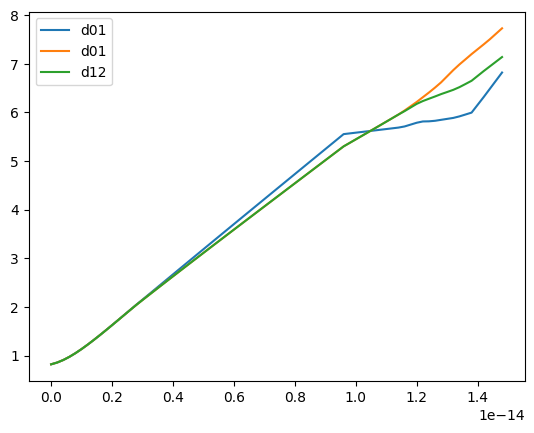

In [12]:
#with hardware noise
#8096 shots
plt.plot(times[:75], distance01[1:], label='d01')
plt.plot(times[:75], distance02[1:], label='d01')
plt.plot(times[:75], distance12[1:], label='d12')
plt.legend()
plt.show()

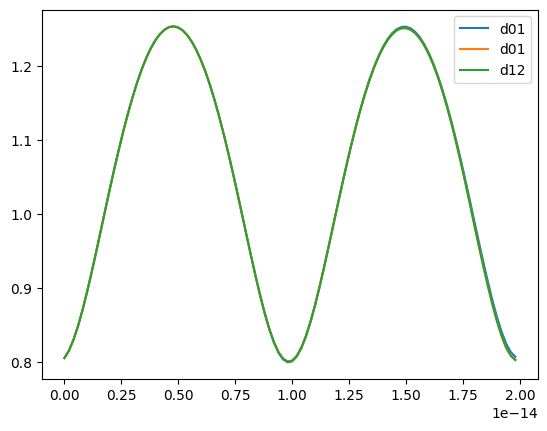

In [18]:
#no hardware noise
#2048 shots
plt.plot(times, distance01[1:], label='d01')
plt.plot(times, distance02[1:], label='d01')
plt.plot(times, distance12[1:], label='d12')
plt.legend()
plt.show()

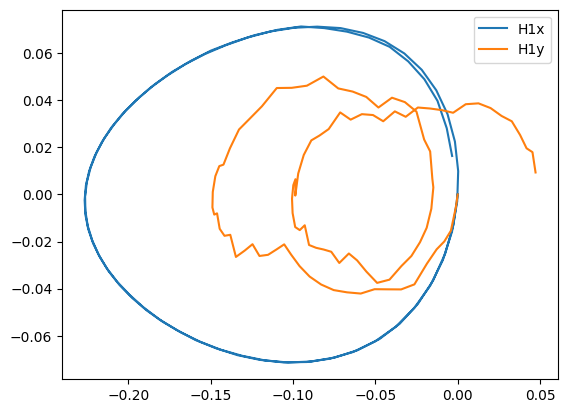

In [39]:
#no hardware noise
momentumnp = np.array(momentum)
coordsnp = np.array(coords)
plt.plot(coordsnp[:,0], momentumnp[:,0], label='H1x')
plt.plot(coordsnp[:,1], momentumnp[:,1], label='H1y')
# plt.plot(coordsnp[:,2], momentumnp[:,2], label='H2x')
# plt.plot(coordsnp[:,3], momentumnp[:,3], label='H2y')
# plt.plot(coordsnp[:,4], momentumnp[:,4], label='H3x')
# plt.plot(coordsnp[:,5], momentumnp[:,5], label='H3y')
plt.legend()
plt.show()